In [1]:
import splitwavepy as sw
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
dat = sw.Data(delta=0.1, noise=0.01, split=(30, 1.3))
x0 = dat.x
y0 = dat.y

The correlation and the variance of the data are connected by the covariance.

The Pearson correlation coefficient $\rho$, is maximised between the *fast* and *slow* components when the data are corrected for splitting.
$\rho(X,Y) = \frac{\operatorname{cov}(X,Y)}{\sigma_{X}\sigma_{Y}}$

The variance.  This is equivalent to the energy.  The energy is maximised on the *polarisation* component and minimised on the *transverse* component when the data are corrected for splitting.
$\operatorname{var}(X) = \operatorname{cov}(X,X)$

The covariance is defined as:
$\operatorname{cov}(X,Y) = \operatorname {E} [(X-\operatorname{E}[X])(Y-\operatorname{E}[Y])]$, or calculated using:
$\operatorname{cov}(X,Y) = \frac{1}{n} \Sigma^{n}_{i=1}(x_i - \mu_x)(y_i - \mu_y)$

A faster (but potentially numerically unstable) way to calculate the covariance is:
$\operatorname{cov}(X,Y) = \operatorname {E} [XY] - \operatorname {E}[X] \operatorname {E}[Y]$

The variance-covariance matrix:
$\Sigma _{ij}=\operatorname {cov} (X_{i},X_{j})=\operatorname {E} [(X_{i}-\mu _{i})(X_{j}-\mu _{j})]=\operatorname {E} [X_{i}X_{j}]-\mu _{i}\mu _{j}$




In [42]:
def rotate(x,y,degrees):
    """row 0 is x-axis and row 1 is y-axis,
       rotates from x to y axis
       e.g. N to E if row 0 is N cmp and row1 is E cmp"""
    ang = math.radians(degrees)
    rot = np.array([[ np.cos(ang), np.sin(ang)],
                    [-np.sin(ang), np.cos(ang)]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def rot2(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = np.array([[ cang, sang],
                    [-sang, cang]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def get_c(dx, dy):
    c = np.empty((2, 2))
    c[0][0] = np.sum(dx**2)
    c[0][1] = c[1][0] = np.sum(dx*dy)
    c[1][1] = np.sum(dy**2)
    return c / (np.sqrt(c[0][0]) * np.sqrt(c[1][1]))

def slagchop(x, y, w0, w1, slag):
    d = int(slag/2)
    return x[w0+d: w1+d], y[w0-d: w1-d] 

def running_mean(x, w0, w1, slags):
    d = int(slags[-1]/2)
    x = x[w0-d: w1+d]
    n = w1-w0
    return np.convolve(x, np.ones((n,))/n, mode='valid')

def rotmat(ang):
    sang = math.sin(ang)
    cang = math.cos(ang)
    return np.array([[ cang, sang],
                    [-sang, cang]])

# different from np
def cov1(x, y):
    c = np.empty((2, 2))
    n = x.size
    x = x - np.mean(x)
    y = y - np.mean(y)
    exx = np.sum(x*x)
    exy = np.sum(x*y)
    eyy = np.sum(y*y)
    ex = np.sum(x)
    ey = np.sum(y)
    c[0, 0] = exx - ex*ex
    c[0, 1] = c[1, 0] = exy - ex*ey
    c[1, 1] = eyy - ey*ey
    return c / n

# different from np (ratios same)
# faster than cov1 and np
def cov2(x, y):
    c = np.empty((2, 2))
    exx = np.mean(x*x)
    exy = np.mean(x*y)
    eyy = np.mean(y*y)
    ex = np.mean(x)
    ey = np.mean(y)
    c[0, 0] = exx - ex*ex
    c[0, 1] = c[1, 0] = exy - ex*ey
    c[1, 1] = eyy - ey*ey
    return c

# also slower than cov2
def cov3(x, y):
    c = np.empty((2, 2))
    ex = np.mean(x)
    ey = np.mean(y)
    dx = x - ex
    dy = y - ey
    c[0, 0] = np.mean(dx * dx)
    c[0, 1] = c[1, 0] = np.mean(dx * dy)
    c[1, 1] = np.mean(dy * dy)
    return c

# different from np (ratios same)
# faster than cov1 and np
def cov(x, y):
    c = np.empty((2, 2))
    exx = np.mean(x*x)
    exy = np.mean(x*y)
    eyy = np.mean(y*y)
    ex = np.mean(x)
    ey = np.mean(y)
    c[0, 0] = exx - ex*ex
    c[0, 1] = c[1, 0] = exy - ex*ey
    c[1, 1] = eyy - ey*ey
    return c

# slower
# def running_mean2(x, w0, w1, maxslag):
#     d = int(maxslag/2)
#     x = x[w0-d: w1+d]
#     n = w1-w0
#     cumsum = np.cumsum(np.insert(x, 0, 0))
#     return (cumsum[n:] - cumsum[:-n]) / float(n)


In [43]:
degs = np.linspace(0, 180, 180, endpoint=False)
lags = np.linspace(0, 8, 60)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))

def gridcov(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
#             print(ii,jj,c)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# gridcov2 -- using the "trick" that cov(x,y) =  E[xy] - E[x]E[y] 
# this is slower than gridcov
# probably because the calculation of dx and dy is useful for calculating variances quickly.
def gridcov2(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
#             dx, dy = wx - meanx[slag], wy - meany[slag]
            exy = np.mean(wx * wy)
            ex = meanx[slag]
            ey = meany[slag]
            c[0, 0] = np.var(wx)
            c[1, 0] = c[0, 1] = exy - ex * ey
            c[1, 1] = np.var(wy)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# gridcov3 -- using numpy.cov function explicitly
# this is even slower than gridcov2.
def gridcov3(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            gridcov[ii, jj, :, :] = np.cov(wx,wy)
            jj += 1
        ii += 1
    return gridcov

# gridcov4 -- don't precalculate means
# as expected this is slower than gridcov, but faster than others.
# something like this is probably needed if source correction needs to be applied
def gridcov4(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            mx, my = np.mean(wx), np.mean(wy)
            dx, dy = wx - mx, wy - my
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov

# gridcov5 -- use cov in list comprehension
def gridcov5(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # grid search
    gridcov = [ [ cov(*slagchop(*rot, w0, w1, slag)) for slag in slags ] for rot in rot_data ]
    return np.asarray(gridcov)



In [5]:
x, y, w0, w1 = dat.x, dat.y, dat._w0(), dat._w1()

In [6]:
%timeit gridcov(x, y, w0, w1, degs, slags)
c = gridcov(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# # silver and chan transenergy method
# pol = 0
# var = np.empty(c.shape)
# # rotmats = np.asarray([ rotmat(math.radians(pol-deg)) for deg in degs ])
# # var = np.tensordot(c, rotmats, 2)
# for ii in range(degs.size):
#     r = rotmat(math.radians(pol-degs[jj]))
#     for jj in range(slags.size):
#         var[ii,jj,:,:] = np.dot(r, c[ii,jj,:,:])
        
# var1 = var[:,:,0,0]
# var2 = var[:,:,1,1]



203 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


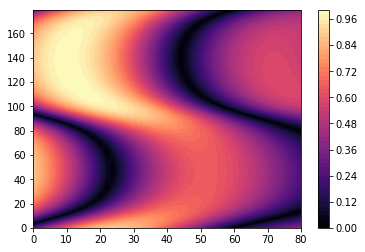

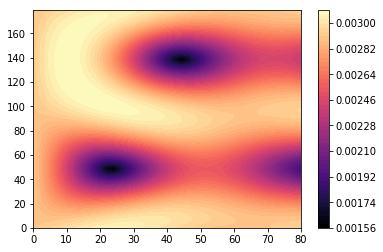

In [7]:
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

498 ms ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


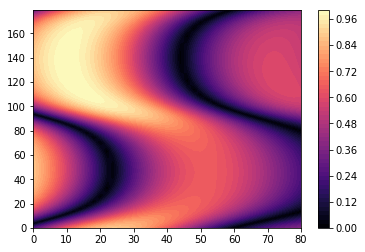

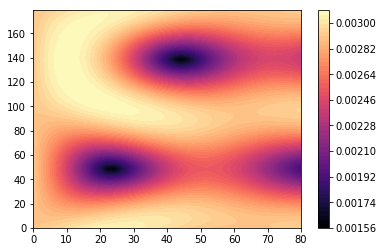

In [8]:
%timeit gridcov2(x, y, w0, w1, degs, slags)

c = gridcov2(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

482 ms ± 39.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


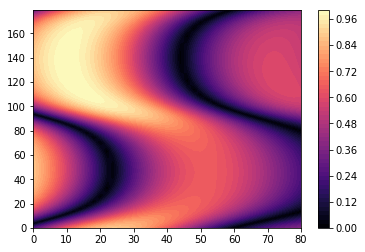

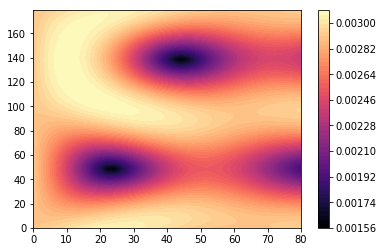

In [9]:
%timeit gridcov3(x, y, w0, w1, degs, slags)

c = gridcov2(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

294 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


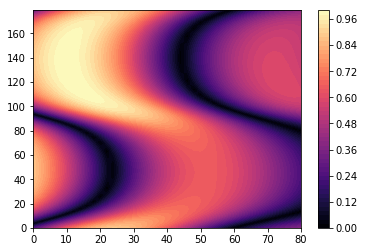

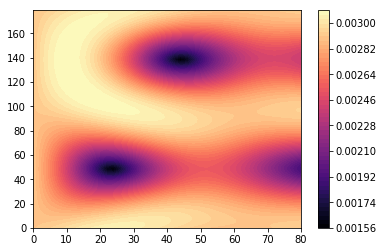

In [10]:
%timeit gridcov4(x, y, w0, w1, degs, slags)

c = gridcov4(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

In [11]:
%timeit gridcov2(x, y, w0, w1, degs, slags)

420 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
dat._w1()

659

In [13]:
np.convolve?

In [14]:
eigvals, eigvecs = np.linalg.eigh(c[:,:])

In [15]:
eigvals[:,:,0]

array([[ 0.00018692,  0.00017661,  0.00016354, ...,  0.00017617,
         0.0001732 ,  0.00017074],
       [ 0.00018692,  0.00017898,  0.00016802, ...,  0.00017533,
         0.00017239,  0.00016985],
       [ 0.00018692,  0.00018137,  0.00017259, ...,  0.0001757 ,
         0.00017283,  0.00017025],
       ..., 
       [ 0.00018692,  0.00016971,  0.00015065, ...,  0.00018568,
         0.00018289,  0.00018095],
       [ 0.00018692,  0.00017198,  0.00015485, ...,  0.00018136,
         0.00017847,  0.0001763 ],
       [ 0.00018692,  0.00017428,  0.00015915, ...,  0.00017818,
         0.00017523,  0.00017289]])

In [16]:
degs = np.linspace(0, 180, 90, endpoint=False)
lags = np.linspace(0, 8, 30)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))
%timeit gridcov(x, y, w0, w1, degs, slags)

67.4 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


378 ms ± 48.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


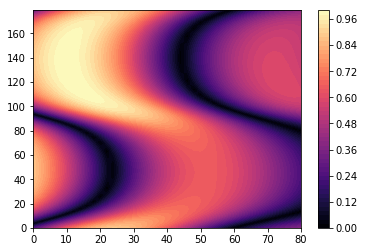

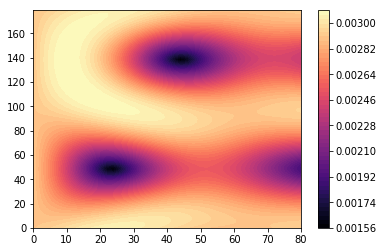

In [44]:
%timeit gridcov5(x, y, w0, w1, degs, slags)
c = gridcov5(x, y, w0, w1, degs, slags)

# fast slow correlation method
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)

# silver and chan eigenvalue method
eigvals, eigvecs = np.linalg.eigh(c[:, :])
lam2 = eigvals[:, :, 0]
lam1 = eigvals[:, :, 1]

# plots
ll, dd = np.meshgrid(slags, degs)
# plot rho
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()
# plot lam1
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

In [38]:
%timeit np.cov(x, y, bias=1)
print('numpy\n', np.cov(x,y))

%timeit cov1(x, y)
print('cov1\n', cov1(x, y))

%timeit cov2(x, y)
print('cov2\n', cov2(x, y))

%timeit cov3(x, y)
print('cov3\n', cov3(x, y))

60 µs ± 315 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
numpy
 [[  9.66464777e-04   5.65990167e-05]
 [  5.65990167e-05   6.87845560e-05]]
50.1 µs ± 163 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
cov1
 [[  9.65487563e-04   5.65417881e-05]
 [  5.65417881e-05   6.87150064e-05]]
44.8 µs ± 406 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
cov2
 [[  9.65487563e-04   5.65417881e-05]
 [  5.65417881e-05   6.87150064e-05]]
52.2 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
cov3
 [[  9.65487563e-04   5.65417881e-05]
 [  5.65417881e-05   6.87150064e-05]]


In [41]:
a = np.cov(x, y)
b = cov2(x, y)
print('var1/var2')
print(a[0][0]/a[1][1])
print(b[0][0]/b[1][1])
print('rho')
print(a[0][1]/(np.sqrt(a[0][0])*np.sqrt(a[1][1])))
print(b[0][1]/(np.sqrt(b[0][0])*np.sqrt(b[1][1])))

var1/var2
14.0506072016
14.0506072016
rho
0.219518133515
0.219518133515


In [34]:
%timeit cov2(x, y)

44.7 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
np.cov(x, y)

In [ ]:
x = np.random.random((10, 2))
y = np.random.random((10, 2))

In [ ]:
c0 = np.cov(x, y)

In [ ]:
c0

In [ ]:
np.cov(x[:,0], y[:,0])

In [50]:
sw.core.core.split??

In [51]:
def slagchop_srccorr(x, y, w0, w1, slag, srcfast, srcslag):
    x, y = rot2(x, y, srcfast)
    x, y = lag(x, y, srcslag)
    x, y = rot2(x, y, -srcfast)
    d = int(slag/2) - int(srcslag/2)
    return x[w0+d: w1+d], y[w0-d: w1-d]

def gridcov_srcorr(x, y, w0, w1, degs, slags, srcfast, srcslag):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        jj = 0
        for slag in slags:
            wx, wy  = slagchop_srccorr(*rot, w0, w1, slag, srcfast, srcslag)
            mx, my = np.mean(wx), np.mean(wy)
            dx, dy = wx - mx, wy - my
            n = dx.size
            c[0, 0] = np.sum(dx * dx)
            c[1, 0] = c[0, 1] = np.sum(dx * dy)
            c[1, 1] = np.sum(dy * dy)
            c = c / n
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov